# Recommendation System on Movie

Library Import

In [18]:
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


## Data Loading

Dataset Preparation

Note that dataset can be found here: https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [4]:
dataset_link = "tmdb_5000_movies.csv"

df = pd.read_csv(dataset_link)
df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

Define Each Fields

In [5]:
id_field = "id"
budget_field = "budget"
genres_field = "genres"
homepage_field = "homepage"
keyword_field = "keywords"
original_language_field = "original_language"
original_title_field = "original_title"
overview_field = "overview"
popularity_field = "popularity"
production_companies_field = "production_companies"
production_countries_field = "production_countries"
release_date_field = "release_date"
revenue_field = "revenue"
runtime_field = "runtime"
spoken_languages_field = "spoken_languages"
status_field = "status"
tagline_field = "tagline"
title_field = "title"
vote_average_field = "vote_average"
vote_count_field = "vote_count"

Define Fields

Note that we also remove unecessary fields.

In [6]:
fields = df.columns.to_list()
target = original_title_field

fields.remove(id_field)
fields.remove(homepage_field)
fields.remove(title_field)
fields.remove(original_title_field)
fields.remove(revenue_field)
fields.remove(vote_count_field)

print(fields)

['budget', 'genres', 'keywords', 'original_language', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'status', 'tagline', 'vote_average']


See info on each field

In [7]:
df[fields].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   keywords              4803 non-null   object 
 3   original_language     4803 non-null   object 
 4   overview              4800 non-null   object 
 5   popularity            4803 non-null   float64
 6   production_companies  4803 non-null   object 
 7   production_countries  4803 non-null   object 
 8   release_date          4802 non-null   object 
 9   runtime               4801 non-null   float64
 10  spoken_languages      4803 non-null   object 
 11  status                4803 non-null   object 
 12  tagline               3959 non-null   object 
 13  vote_average          4803 non-null   float64
dtypes: float64(3), int64(1), object(10)
memory usage: 525.5+ KB


View Statistics for Each Fields

In [8]:
df[fields].describe()

,budget,popularity,runtime,vote_average
count,4.803000e+03,4803.000000,4801.000000,4803.000000
mean,2.904504e+07,21.492301,106.875859,6.092172
std,4.072239e+07,31.816650,22.611935,1.194612
min,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,94.000000,5.600000
50%,1.500000e+07,12.921594,103.000000,6.200000
75%,4.000000e+07,28.313505,118.000000,6.800000
max,3.800000e+08,875.581305,338.000000,10.000000


## Data Preprocessing

### Convert Number Fields to Word

In [9]:
def budget_to_string(row):
    if row >= 5000000:
        return "expensive"
    else:
        return "cheap"

def popularity_to_string(row):
    if row >= 12:
        return "Popular"
    else:
        return "Rare"

def runtime_to_string(row):
    if row >= 94:
        return "Long"
    else:
        return "Short"

def vote_average_to_string(row):
    if row >= 7.5:
        return "Good"
    elif row > 5.6 and row < 7.5:
        return "Average"
    else:
        return "Poor"

number_to_word_converted_df = df[fields].copy()

number_to_word_converted_df[budget_field] = number_to_word_converted_df[budget_field].apply(budget_to_string)
number_to_word_converted_df[popularity_field] = number_to_word_converted_df[popularity_field].apply(popularity_to_string)
number_to_word_converted_df[runtime_field] = number_to_word_converted_df[runtime_field].apply(runtime_to_string)
number_to_word_converted_df[vote_average_field] = number_to_word_converted_df[vote_average_field].apply(vote_average_to_string)

number_to_word_converted_df

,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,vote_average
0,expensive,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",Popular,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,Long,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Average
1,expensive,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",Popular,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,Long,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Average
2,expensive,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,Popular,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,Long,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Average
3,expensive,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,Popular,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,Long,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,Good
4,expensive,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",Popular,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,Long,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,cheap,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi just wants to play his guitar and ...,Popular,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,Short,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",Average
4799,cheap,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",[],en,A newlywed couple's honeymoon is upended by th...,Rare,[],[],2011-12-26,Short,[],Released,A newlywed couple's honeymoon is upended by th...,Average
4800,cheap,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"""Signed, Sealed, Delivered"" introduces a dedic...",Rare,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-10-13,Long,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Average
4801,cheap,[],[],en,When ambitious New York attorney Sam is sent t...,Rare,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-05-03,Long,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Yorker in Shanghai,Average


### Convert JSON in fields of Movie Dataset into string

In [10]:
def convert_json_field_in_df_into_strings(df, df_field, json_field):

    """
    Convert JSON fields to string, by taking the dataframe and a field, a json field, which returns a list of string

    from a specific field in a dataframe

    Below are the explanation of parameters used.
    * df: dataframe to be used
    * df_field: field in dataframe, to convert json into strings
    * json_field: one field to be kept from json inside the data field in dataframe.

    Consider the example:

    | id | movie_name | movie_genres |

    | 1 | a           | {"id": 1, "name": "action"}, {"id": 2, "name": "romance"} | 

    | 2 | b           | {"id": 1, "name": "slice of life"}, {"id": 2, "name": "food"} |

    If we use the function: 
    
    convert_json_field_in_df_into_strings(df, "movie_genres", "name")

    This gives us the list of string from all rows in movie_genres field.

    """

    json_data = json.loads(df[df_field].to_json())
    json_values = list(json_data.values())

    list_of_strings = []

    for value in json_values:

        my_string = ""

        dicts = list(json.loads(value))[:]

        for dict_value in dicts:
            my_string += f"{dict_value[json_field]} "
        list_of_strings.append(my_string[:-1])

    return list_of_strings

json_converted_df = number_to_word_converted_df.copy()

json_field = "name"

json_converted_df[genres_field] = convert_json_field_in_df_into_strings(json_converted_df, genres_field, json_field)
json_converted_df[keyword_field] = convert_json_field_in_df_into_strings(json_converted_df, keyword_field, json_field)
json_converted_df[spoken_languages_field] = convert_json_field_in_df_into_strings(json_converted_df, spoken_languages_field, json_field)
json_converted_df[production_companies_field] = convert_json_field_in_df_into_strings(json_converted_df, production_companies_field, json_field)
json_converted_df[production_countries_field] = convert_json_field_in_df_into_strings(json_converted_df, production_countries_field, json_field)

json_converted_df

,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,vote_average
0,expensive,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,en,"In the 22nd century, a paraplegic Marine is di...",Popular,Ingenious Film Partners Twentieth Century Fox ...,United States of America United Kingdom,2009-12-10,Long,English Español,Released,Enter the World of Pandora.,Average
1,expensive,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,en,"Captain Barbossa, long believed to be dead, ha...",Popular,Walt Disney Pictures Jerry Bruckheimer Films S...,United States of America,2007-05-19,Long,English,Released,"At the end of the world, the adventure begins.",Average
2,expensive,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,en,A cryptic message from Bond’s past sends him o...,Popular,Columbia Pictures Danjaq B24,United Kingdom United States of America,2015-10-26,Long,Français English Español Italiano Deutsch,Released,A Plan No One Escapes,Average
3,expensive,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,en,Following the death of District Attorney Harve...,Popular,Legendary Pictures Warner Bros. DC Entertainme...,United States of America,2012-07-16,Long,English,Released,The Legend Ends,Good
4,expensive,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,en,"John Carter is a war-weary, former military ca...",Popular,Walt Disney Pictures,United States of America,2012-03-07,Long,English,Released,"Lost in our world, found in another.",Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,cheap,Action Crime Thriller,united states–mexico barrier legs arms paper k...,es,El Mariachi just wants to play his guitar and ...,Popular,Columbia Pictures,Mexico United States of America,1992-09-04,Short,Español,Released,"He didn't come looking for trouble, but troubl...",Average
4799,cheap,Comedy Romance,,en,A newlywed couple's honeymoon is upended by th...,Rare,,,2011-12-26,Short,,Released,A newlywed couple's honeymoon is upended by th...,Average
4800,cheap,Comedy Drama Romance TV Movie,date love at first sight narration investigati...,en,"""Signed, Sealed, Delivered"" introduces a dedic...",Rare,Front Street Pictures Muse Entertainment Enter...,United States of America,2013-10-13,Long,English,Released,NaN,Average
4801,cheap,,,en,When ambitious New York attorney Sam is sent t...,Rare,,United States of America China,2012-05-03,Long,English,Released,A New Yorker in Shanghai,Average


### Combine All Strings into One Text

In [11]:
def combine_all_strings_from_df(df, fields, whitespace_split = ','):
    """
    Combine all strings from one df and all fields. 
    
    If you'd like to put something between words, provide whitespace_split parameter.
    """
    df_strings = df.to_string(header = False,
                       index = False,
                       columns = fields,
                       index_names = False).split('\n')

    all_strings = [" ".join(s.split()) for s in df_strings]

    return all_strings

df_strings = combine_all_strings_from_df(json_converted_df, fields)

print(df_strings[0])

expensive Action Adventure Fantasy Science Fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d en In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Popular Ingenious Film Partners Twentieth Century Fox Film Corporation Dune Entertainment Lightstorm Entertainment United States of America United Kingdom 2009-12-10 Long English Español Released Enter the World of Pandora. Average


### Transform the Text into TfIdfVectorizer

In [12]:
def simple_space_tokenizer(value):
    return value.split(' ')

tf_idf_vectorizer = TfidfVectorizer(tokenizer = simple_space_tokenizer)
vector_components = tf_idf_vectorizer.fit_transform(df_strings)

print("Vector Components Size:", vector_components.shape)
print("Number of Non-Empty Elements:", (vector_components != 0).sum())

Vector Components Size: (4803, 45299)
Number of Non-Empty Elements: 368742


In [13]:
sample_one_vector_component = vector_components.todense()[0]
sample_one_vector_component.shape

print(sample_one_vector_component)

[[0. 0. 0. ... 0. 0. 0.]]


### Measure Similarity using Cosine Similarity

In [14]:
movie_similarity_values = cosine_similarity(vector_components)
movie_similarity_values.shape

(4803, 4803)

In [15]:
movie_similarity_df = pd.DataFrame(
    movie_similarity_values,
    index = df[target],
    columns = df[target]
)
movie_similarity_df

original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
original_title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.000000,0.048555,0.045384,0.034316,0.168967,0.068135,0.032482,0.075392,0.032738,0.045055,...,0.017174,0.017912,0.045874,0.055362,0.022036,0.027763,0.015318,0.038808,0.024795,0.018952
Pirates of the Caribbean: At World's End,0.048555,1.000000,0.049263,0.046165,0.096920,0.070680,0.065146,0.063656,0.053454,0.040648,...,0.011717,0.033720,0.039480,0.045742,0.040584,0.046898,0.018950,0.041262,0.039448,0.032692
Spectre,0.045384,0.049263,1.000000,0.048977,0.043470,0.053696,0.035396,0.075951,0.034606,0.036294,...,0.042091,0.018033,0.035651,0.021156,0.039721,0.046427,0.013363,0.036183,0.033159,0.028079
The Dark Knight Rises,0.034316,0.046165,0.048977,1.000000,0.029399,0.041286,0.044373,0.070803,0.040769,0.212832,...,0.014366,0.018553,0.042198,0.043911,0.029331,0.037856,0.016221,0.030032,0.040633,0.025419
John Carter,0.168967,0.096920,0.043470,0.029399,1.000000,0.047992,0.080559,0.091839,0.029932,0.032593,...,0.024849,0.021450,0.037462,0.037078,0.047185,0.042264,0.012836,0.035017,0.041912,0.024715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
El Mariachi,0.027763,0.046898,0.046427,0.037856,0.042264,0.025535,0.042744,0.056808,0.040759,0.015418,...,0.016570,0.032871,0.054658,0.026897,0.059767,1.000000,0.010808,0.025514,0.044892,0.032200
Newlyweds,0.015318,0.018950,0.013363,0.016221,0.012836,0.016102,0.016058,0.015077,0.007618,0.007660,...,0.013717,0.019284,0.024239,0.024739,0.021034,0.010808,1.000000,0.029643,0.025684,0.019013
"Signed, Sealed, Delivered",0.038808,0.041262,0.036183,0.030032,0.035017,0.053049,0.037833,0.045087,0.032610,0.031052,...,0.023987,0.033966,0.047595,0.046583,0.028549,0.025514,0.029643,1.000000,0.040145,0.030362


In [16]:
def get_recommendation_system(name, 
                              similarity_df, 
                              additional_info_df, 
                              k = 5):

    copy_similarity_value = similarity_df.copy()

    most_similar_indexes = copy_similarity_value.loc[:, name].to_numpy().argpartition(range(-1, -k, -1))

    closest_values = similarity_df.columns[most_similar_indexes[-1: -(k+2):-1]]

    return pd.DataFrame(closest_values).merge(additional_info_df).head(k)

get_recommendation_system("Scream 3", movie_similarity_df, df, 5)

,original_title,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,Scream 3,40000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,4234,"[{""id"": 2546, ""name"": ""mask""}, {""id"": 2573, ""n...",en,"A murdering spree begins to happen again, this...",24.992057,"[{""name"": ""Konrad Pictures"", ""id"": 85}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-02-03,161834276,116.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Someone has taken their love of trilogies one ...,Scream 3,5.7,736
1,Scream,14000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 27, ""name...",NaN,4232,"[{""id"": 3335, ""name"": ""halloween""}, {""id"": 102...",en,A killer known as Ghostface begins killing off...,45.996110,"[{""name"": ""Woods Entertainment"", ""id"": 979}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1996-12-20,173046663,111.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Someone has taken their love of scary movies o...,Scream,7.0,1476
2,Scream 2,24000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,4233,"[{""id"": 6812, ""name"": ""film festivals""}, {""id""...",en,Two years after the terrifying events that occ...,35.244037,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-12-09,172363301,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Someone has taken their love of sequels one st...,Scream 2,6.1,840
3,Scream 4,40000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",http://www.scream-4.com/,41446,"[{""id"": 798, ""name"": ""sheriff""}, {""id"": 3096, ...",en,"Sidney Prescott, now the author of a self-help...",35.219260,"[{""name"": ""Dimension Films"", ""id"": 7405}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2011-04-11,97138686,111.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,New Decade. New Rules.,Scream 4,6.1,902
4,Scary Movie 3,48000000,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,4256,"[{""id"": 12416, ""name"": ""horror spoof""}]",en,In the third installment of the Scary Movie fr...,36.585509,"[{""name"": ""Dimension Films"", ""id"": 7405}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-10-24,220673217,84.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Great trilogies come in threes.,Scary Movie 3,5.8,912


## Post Recommendation Data Visualization

See the distribution of similarity score from the sample query.

[0.03143011 0.05181378 0.04622345 ... 0.04898577 0.02829066 0.03202835]


<AxesSubplot:ylabel='Density'>

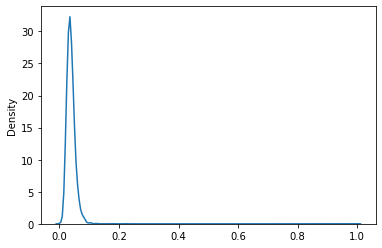

In [27]:
sns.kdeplot(x = movie_similarity_df["Scream 3"].values)

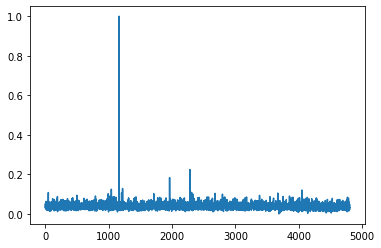

In [28]:
plt.plot(movie_similarity_df["Scream 3"].values)